In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../../img"
import time
import scipy
from scipy.optimize import fmin

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array 
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [3]:
# gen trimap (for checking against bad quality trimaps)
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri3.png',0)
# tri = cv2.resize(img,(images[0].shape[0],images[0].shape[1]))
def gen_tri(img,iters):
    """
    generates trimap given a matte or better quality tri-map
    :param img: 
    returns trimap 
    """
    kernel = np.ones((5,5),np.uint8)
    tri = cv2.erode(img,kernel,iterations = iters)

    for i in range(tri.shape[0]):
        for j in range(tri.shape[1]):
            if(tri[i][j]!=255 and tri[i][j]!=0):
                tri[i][j] = 127
    return tri

In [8]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri1.jpg'),0)


new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg3.png'))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0])) 

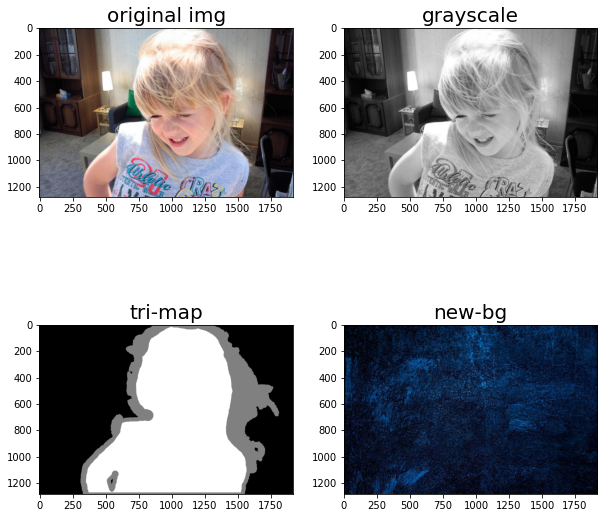

In [9]:
display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



In [10]:
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))
    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def doubleDifferential(img, factor):
    """
    Utility Function to Generate the Double Differential for the Poisson Equation
    :param img: A numpy array representing the Grayscale version of Image
    :param factor: A constant used to divide the first order differential before calculating the second order
                    differential. It can be a constant or a numpy array of the same size as img
    :returns : Two Numpy arrays representing the double differential in Y and X respectively
    """
    dy, dx = np.gradient(img)
    d2y, _ = np.gradient(dy/factor)
    _, d2x = np.gradient(dx/factor)
    return d2y, d2x
    
    
def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate 
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation
    
    :returns :A numpy array representing Matte produced and time taken to calculate it 
    """
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and 
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground 
    :param B: A numpy array representing Approximate Background 
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
   
    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :returns estimated alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

def matting_combined(tri, img_gray):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}

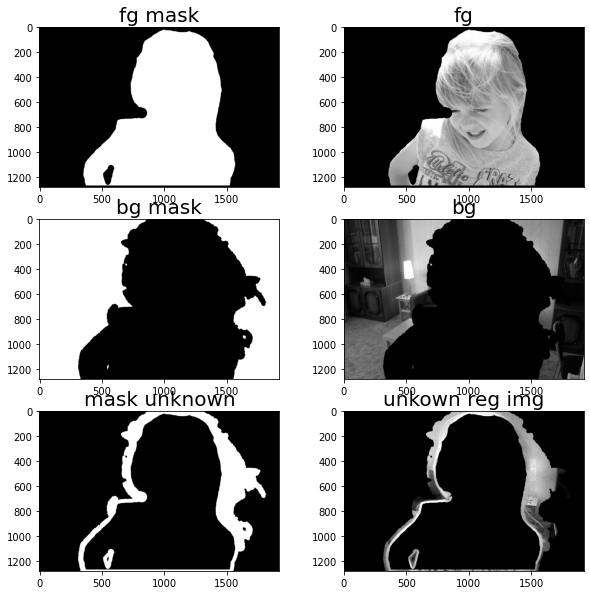

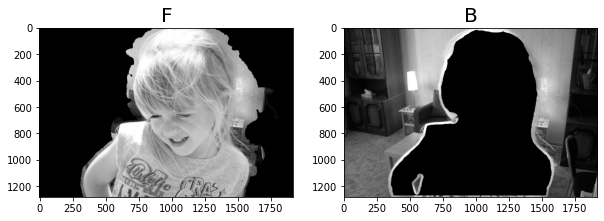

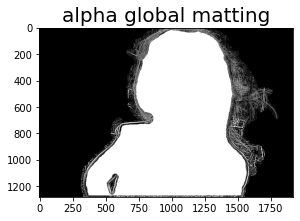

In [11]:
#     return alpha
# alpha = matting_combined(tri, img_gray)
all_data = matting_combined(tri, img_gray)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()
## NOW all_data VARIABLE CONTAINS img, img_GRAY, ALPHA, DIFF, F, B, UNKNOWN


# display_img_arr([new_img ], 1,1,(10,10),['img with new bg'])

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

# Alpha blending

### I = α F + (1 − α )B

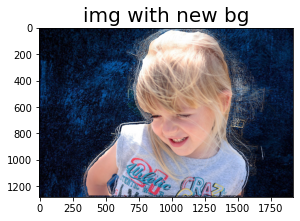

In [12]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img_global = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img_global ], 1,2,(10,10),['img with new bg'])

In [13]:
#alpha blending  
alpha = all_data['alpha']
new_img_global = alpha_blend(new_bg,alpha,img )
# display_img_arr([new_img_global], 1,2,(10,10),['new image'])

## Selecting Regions of Interest Interactively

In [15]:
# get ROI from Select_roi.py

!python3 Select_roi.py ../../img/img1.jpg
#returns top, left, bottom, right coordinates used for selectiong local regions for local matting and doing refinement
#Usage: Select region where matte to be improved, after selecting type "quit"
#coords selected are saved in coords.txt file

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
(283, 763, 443, 221)


In [16]:
def read_coords():
    """
    Utility Function to read Coords selected and find the corner points of the ROI 
    """
    f = open('coords.txt','r')
    coords = f.read()
    f.close()
    # converting to int
    coord_int = []
    coords_i = coords.split(' ')
    for c in coords_i:
        if(c!=''):
            coord_int.append(int(c))
    return coord_int
coords =  read_coords() 
print(coords)
left, top,add_right, add_bottom = coords
right = left + add_right
bottom = top + add_bottom
print(top, bottom, left, right)

[283, 763, 443, 221]
763 984 283 726


## Diffusion Filtering

In [17]:
# !pip install medpy

In [18]:
from medpy.filter.smoothing import anisotropic_diffusion



![diffusion_params.png](../attachments/diffusion_params.png) 

/home/ansh/.local/lib/python3.8/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ansh/.local/lib/python3.8/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


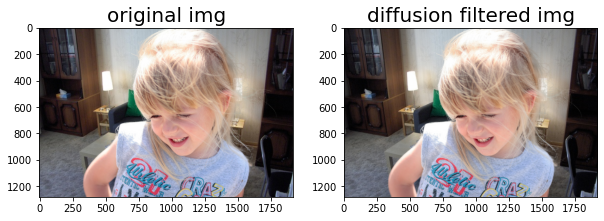

In [19]:
def diffusion(img):
    """
    args: img
    returns new img which is to be passed in for further refinement
    """
    diffused_image = anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1)
    ans = np.round(diffused_image)

    final_ans = np.empty(img.shape, dtype=int)
    for k in range(3):
        for i in range(ans.shape[0]):
            for j in range(ans.shape[1]):
                final_ans[i, j, k] = int(ans[i, j, k])
    return final_ans
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'),0)
new_img = diffusion(img)
display_img_arr([img,new_img], 1,2,(10,10),['original img','diffusion filtered img'])


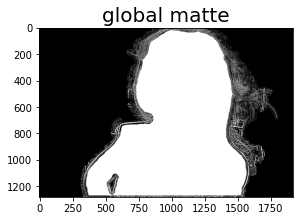

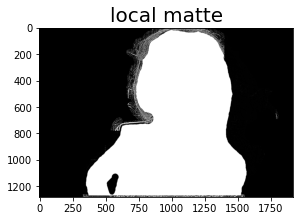

In [21]:
def local_matting(data_dic, top, bottom, left, right):
    """
    Local Matting functions which uses the Matte supplied by Global Matting and 
    Co-ordinates supplied by User to improve the Matte.
    :param data_dic: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    """
    h, w = data_dic['alpha'].shape[0], data_dic['alpha'].shape[1]
    local = 0
    if('local_matte' in data_dic.keys()):
        local = 1
        h, w = data_dic['local_matte'].shape[0], data_dic['local_matte'].shape[1]
        
    
    new_diff = data_dic['diff'][top:bottom+1, left:right+1]
    
    ## APPLYING GAUSSIAN FILTER ON THIS NEW DIFF
    new_diff = ndimage.filters.gaussian_filter(new_diff, 0.9)
    new_diff = np.minimum(np.maximum(new_diff,0),255)
    
    ## EXTRACTING SEGMENTS IN GIVEN RANGE FOR ORIGINAL IMAGE, FOREGROUND AND THE BACKGROUND
    required_img= data_dic['img_gray'].copy()[top:bottom+1, left:right+1]
    required_fg = data_dic['F'].copy()[top:bottom+1,left:right+1]
    required_bg = data_dic['B'].copy()[top:bottom+1,left:right+1]
    required_unknown = data_dic['unknown'].copy()[top:bottom,left:right]
    required_alpha= data_dic['alpha'].copy()[top:bottom+1,left:right+1]
    if(local==1):
        required_alpha= data_dic['local_matte'].copy()[top:bottom+1,left:right+1]
    
    required_inverted_alpha= 1 - required_alpha
    required_mask_unknown = data_dic['mask_unknown'].copy()[top:bottom+1, left:right+1]
    
    
    ## GET DOUBLE DIFFERENTIAL FOR IMG, FOREGROUND AND BACKGROUND
    fg_d2y, fg_d2x = doubleDifferential(required_fg, new_diff)
    bg_d2y, bg_d2x = doubleDifferential(required_bg, new_diff)
    img_d2y, img_d2x = doubleDifferential(required_img, new_diff)
    weighted_fg = required_alpha*(fg_d2x+fg_d2y)
    weighted_bg = required_alpha*(bg_d2x+bg_d2y)
    new_d2alpha = img_d2x + img_d2y - weighted_fg - weighted_bg
    

#     display_img_arr([data_dic['alpha']], 1,2,(10,10),['alpha'])
    matte, time = global_alpha_matting(required_alpha,new_d2alpha,required_mask_unknown, iters= 50, threshold = 0.1, beta = 0.2)
#     display_img_arr([data_dic['alpha'],data_dic['mask_unknown']], 1,2,(10,10),['alpha','mask unkwon'])
    matte = np.minimum(np.maximum(matte,0),1)

    return matte
all_data_2 = all_data.copy()
local_matte =  all_data_2['alpha'].copy()
# print(local_matte.shape)

# # selecting regions which we feel are not correct in matte

top,bottom,left,right = [0,1260,1400,1790]
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)

top,bottom,left,right = [0,1260,250,500]
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)

top,bottom,left,right = [1000,1260,250,700]
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)

top,bottom,left,right = [780,1000,500,800]
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)

all_data_2['local_matte'] = local_matte

display_img_arr([all_data['alpha']], 1,2,(10,10),['global matte'])

display_img_arr([local_matte], 1,2,(10,10),['local matte'])

### Local Poisson Matting vs Global Matting 

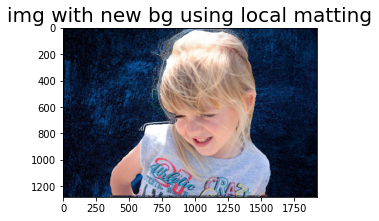

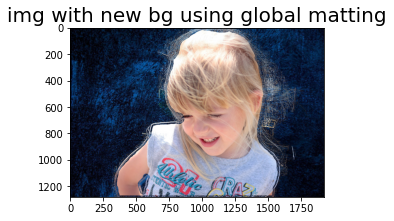

In [22]:
new_img_local = alpha_blend(new_bg,local_matte,img)
display_img_arr([new_img_local], 1,2,(10,10),['img with new bg using local matting'])
display_img_arr([new_img_global], 1,2,(10,10),['img with new bg using global matting'])


##  Alpha blending, generate foreground in new bg

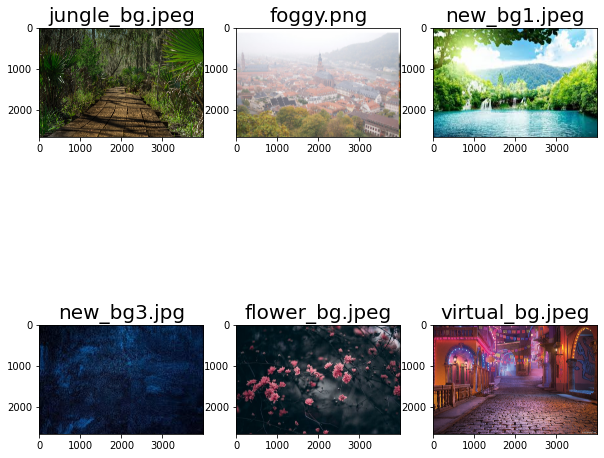

In [24]:
bg_names = ['jungle_bg.jpeg','foggy.png','new_bg1.jpeg','new_bg3.jpg','flower_bg.jpeg','virtual_bg.jpeg','new_bg3.jpg']
bgs,bgs_g = read_img(bg_names)
display_img_arr(bgs, 2,3,(10,10),bg_names)

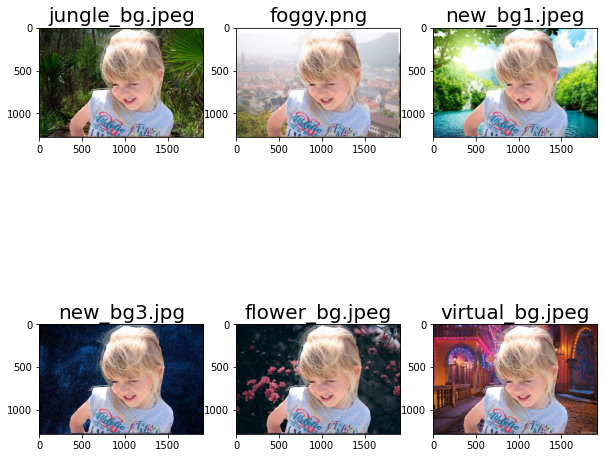

In [25]:
# generate image in new bgs
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img.shape[1],img.shape[0]))
    new_imgs.append(alpha_blend(bg,local_matte,img ))
    

display_img_arr(new_imgs, 2,3,(10,10),bg_names)    

In [26]:
# saving imgages
out_path = '../../outs'
for i,im in enumerate(new_imgs):
    plt.imsave(out_path+'/'+'new_img'+str(i)+'.png',im.astype('uint8'))

## High pass

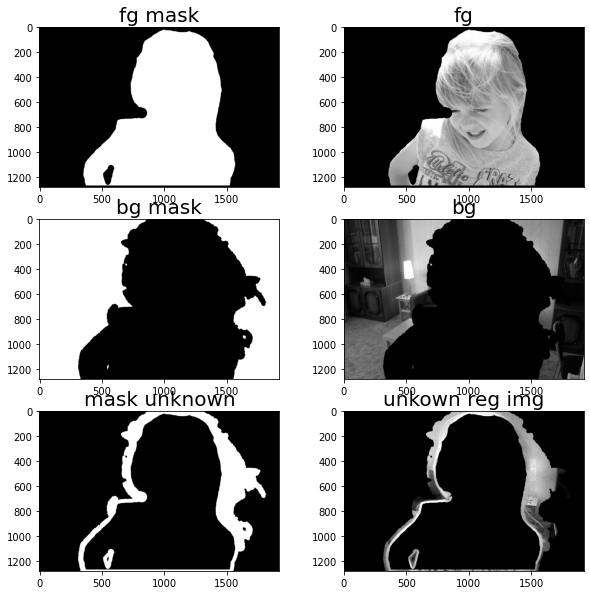

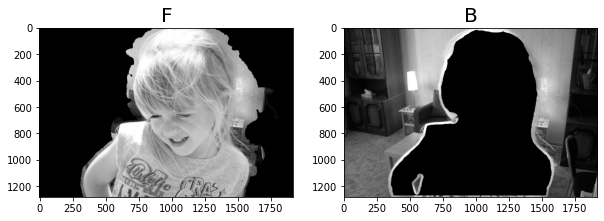

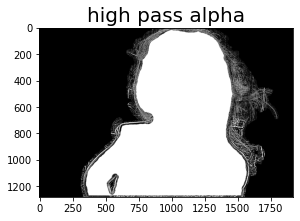

In [28]:
def convolve(img,kernel):
    """
    Utility: convolves image with kernel
    param image
    param kernel
    returns convolved output
    """
    h,w = img.shape
    k_h,k_w = kernel.shape
    
    output = np.zeros([h,w])
    
    padding_img = np.zeros([h+k_h-1,w+k_w-1])
    padding_img[int((k_h-1)/2):int(h+(k_h-1)/2),int((k_w-1)/2):int(w+(k_w-1)/2)] = img
    
    for i in range(k_h,h+k_h):
        for j in range(k_w,w+k_w):
            area_obs = padding_img[i-k_h:i,j-k_w:j]
            val = sum(sum(kernel*area_obs))
            output[i-k_h,j-k_w] = max(0,val)

    
    return np.int64(output)


def highpass(alpha,img,F,B,unknown_seg):
    """
     Utility: Finds the approximate D
    :param alpha: A numpy array representing estimated alpha matte 
    :param img: Input image in gray
    :param F: A numpy array representing Approximate Foreground 
    :param B: A numpy array representing Approximate Background 
    :param unknown_seg: A numpy array representing the pixels in the Unknown Region segment
    :returns : Highpass alpha matte which is clearer
    """
    
    k = 5
    
    gaussian_kernel = np.zeros([k,k])
    
    center = int((k-1)/2)
    sigma_s = 5
    
    for i in range(k):
        for j in range(k):
            gaussian_kernel[i][j] = np.exp(-(((i - center)**2 + (j-center)**2) / (2 * sigma_s * sigma_s)))
    
    grad_y,grad_x = np.gradient(img)
    
    D_y = convolve(grad_y,gaussian_kernel)
    D_x = convolve(grad_x,gaussian_kernel)
    
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)

    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient((grad_y-D_y)/diff)
    _, d2x_alpha = np.gradient((grad_x-D_x)/diff)

    alpha, _ = global_alpha_matting(alpha, d2alpha, unknown_seg)
    alpha = np.minimum(np.maximum(alpha,0),1)
    
    return alpha

img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'),0)

estimate_alpha, F, B, d2alpha, imgs, diff= func_estimate_alpha(tri, img_gray)
mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
high_pass_alpha = highpass(estimate_alpha,img_gray,F,B,mask_unknown) 
display_img_arr([high_pass_alpha], 2,2,(10,10),['high pass alpha'])    

# Refinement

We provide user with various options for refining image.
### High pass
Estimates D using the low-frequency parts of the image gradient:
$$ D = K ∗ ∇I $$

where $$ K = N(p; p_0 , σ^2 ) $$ is a Gaussian filter centered at pixel p_0 and  ∗ is the convolution operator. <br>
The matte is estimates as: ∇α =A(∇I − K ∗ ∇I), 
where (∇I − K ∗ ∇I) corresponds to a highpass filter.

### Boosting brush
It smoothes or sharpens the matte by increasing/decreasing A.
It is modifies the Area Ap to Ap' as:
![boosting.png](../attachments/boosting.png) 
where p0 is the coordinate of the brush center, 
σ and λ are user defined parameters which control the size and strength of the boosting. <br>

Note: These operations require user to select region which is to be improved carefully, using **roi select** as given above and read coords following it which gives coordinates: top, bottom, left right on which operation is applied. These operations act as a tool for incorporating user knowledge in matting to improve results to user's satisfaction. 

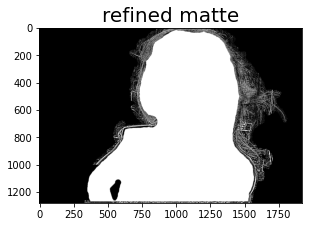

In [32]:

def local_high_pass(all_data,top, bottom, left, right):
    """
     Utility: Finds the approximate D on local regions: regions selected by user for refinement
    :param all_data: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    returns a refined matte from high pass
    """
    h = all_data['alpha'].copy().shape[0]
    w =  all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    refine_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)
    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)
    
    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)
    
    seg = all_data['img_gray'].copy()[top:bottom+1,left:right+1]
    refined_D = cv2.GaussianBlur(seg,(3,3),0)
    dy, dx = np.gradient(seg)
    dy_normalized = dy/diff_2
    d2y, _ = np.gradient(dy_normalized)
    x_normalized = dx/diff_2
    _, d2x = np.gradient(x_normalized)
    segmented_bg = d2y + d2x - refined_D
 
    
    Estimate_alpha_seg = all_data['alpha'].copy()[top:bottom+1,left:right+1]
    D = convolve(Estimate_alpha_seg,(d2yfg + d2xfg)) + convolve((1 - Estimate_alpha_seg),(d2ybg+d2xbg))
    
    matte,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte

def boosting(all_data,top, bottom, left, right,lambda_=5):
    """
     Utility: manipulates A on local regions: regions selected by user for refinement, smoorthens or sharpens depending on value of lambda
    :param all_data: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    : param lambda_ : If lambda > 0, this filter will increase A else decrease A around brush center
    returns a refined matte from high pass
    """
    h, w = all_data['alpha'].copy().shape[0], all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    refine_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)


    sigma = 20
    seg = all_data['img_gray'].copy()[top:bottom+1,left:right+1]
    dy, dx = np.gradient(seg)
    dy_normalised = dy/diff_2
    d2y, _ = np.gradient(dy_normalised)
    dx_normalised = dx/diff_2
    _, d2x = np.gradient(dx_normalised)

    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)

    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)

    A = np.zeros((h,w))
    
    x0 = top + bottom - top +1/2
    y0 = left + right-left +1/2
    for x in range(top,bottom+1+1):
        for y in range(left,right+1+1):
            A[x,y] = (1 + lambda_*np.exp(-1*((abs(x-x0)**2+(abs(y-y0))**2))/(2*sigma**2)))*(1/all_data['diff'].copy()[x,y])
    diff_2 = 1/A[top:bottom+1,left:right+1]
    
    Estimate_alpha_seg = alpha_matte[top:bottom+1,left:right+1]
    
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + (1 - Estimate_alpha_seg)*(d2ybg+d2xbg))
    
    segmented_bg = d2y + d2x - D
    matte1,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte1


#Performing Local Filter Operations on user selected regions and Obtaining the refined alpha Matte

#Apply high pass

all_data_2 = all_data.copy()
refine_matte = all_data_2['alpha'].copy()
iters = 1

coords = [[1000,1260,250,700],[780,1000,500,800]] #regions which user wants to improve in matte
for i in range(iters):
    top, bottom, left, right = coords[i]
    all_data_2['alpha'] = refine_matte
    refine_matte[top:bottom+1,left:right+1] = local_high_pass(all_data_2.copy(),top, bottom, left, right)


#Apply boosting

coords = [[1000,1260,250,700],[780,1000,500,800]] 
iters = 1
for i in range(iters):
    top, bottom, left, right = coords[i]
    all_data_2['alpha'] = refine_matte
    refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)


refine_matte = np.maximum(refine_matte,0)
refine_matte = np.minimum(refine_matte,1)

h, w = all_data_2['alpha'].shape[0], all_data_2['alpha'].shape[1]
refine_matte = refine_matte.reshape(h,w)
display_img_arr([refine_matte], 1,3,(16,40), ['refined matte'])

refined matting results


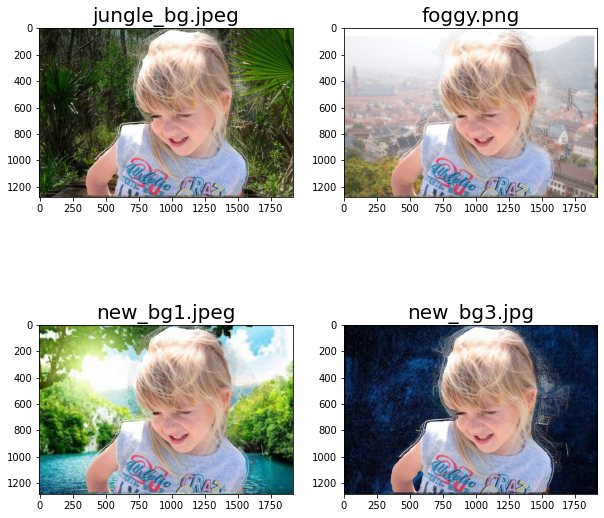

In [33]:
# generate image in new bgs
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img.shape[1],img.shape[0]))
    new_imgs.append(alpha_blend(bg,refine_matte,img ))
    
print('refined matting results')
display_img_arr(new_imgs, 2,2,(10,10),bg_names)  

global matting results


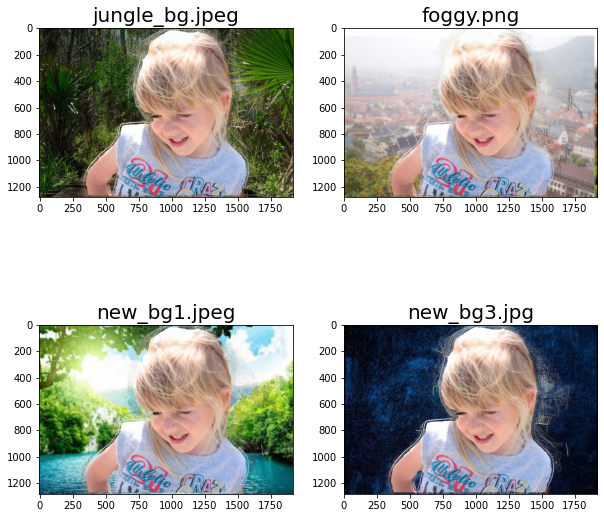

In [34]:
# generate image in new bgs
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img1.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img.shape[1],img.shape[0]))
    new_imgs.append(alpha_blend(bg,alpha,img ))
    
print('global matting results')
display_img_arr(new_imgs, 2,2,(10,10),bg_names)  

Clearly it is seen that refinement improves the matte to great extent